In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spop
import time

# APOGEE data

In [2]:
xpix_chipnum1 = [11.83,
47.65,
90.78,
156.45,
192.24,
200.55,
208.09,
372.78,
410.50,
445.72,
455.44,
559.02,
577.59,
584.76,
679.23,
733.55,
792.02,
825.20,
830.95,
872.14,
881.42,
895.53,
916.37,
918.46,
940.72,
944.20,
953.51,
968.75,
978.77,
984.15,
994.98,
1017.72,
1026.76,
1041.71,
1065.25,
1069.92,
1082.56,
1161.79,
1216.08,
1246.64,
1250.39,
1278.98,
1318.63,
1333.56,
1387.15,
1469.38,
1472.84,
1487.79,
1497.39,
1523.94,
1560.58,
1576.59,
1590.31,
1600.67,
1617.12,
1646.11,
1659.44,
1709.20,
1729.53,
1764.00,
1806.14,
1813.60,
1816.92,
1830.73,
1846.41,
1863.79,
1880.54,
1894.51,
1921.42,
1977.04,
1985.48,
2022.38,
2032.44]

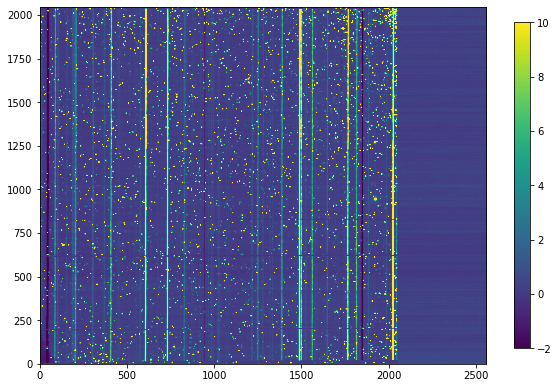

In [3]:
from astropy.io import fits

UNe_arc = fits.open("apR-a-27310005.fits")
data_actualx = UNe_arc[0].data

plt.figure(figsize=(10,10))
plt.imshow(data_actualx, vmin=-2, vmax=10, origin='lower')
plt.colorbar(shrink=0.6)
# plt.xlim(1000,1500)
# plt.ylim(650,750)
plt.show()

## Smaller section

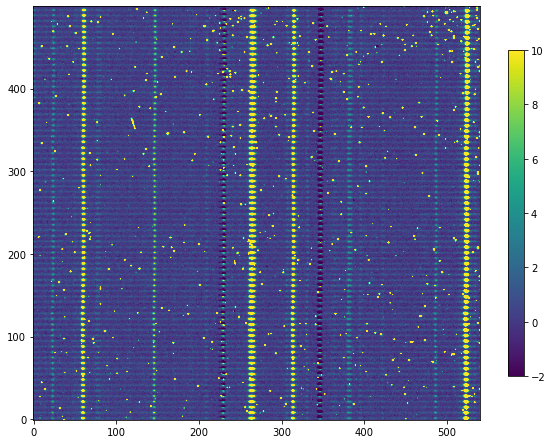

In [4]:
data_actual = UNe_arc[0].data[1500:2000,1500:2040]
plt.figure(figsize=(10,10))
plt.imshow(data_actual, vmin=-2, vmax=10, origin='lower')
plt.colorbar(shrink=0.6)
plt.show()

# Simulated data

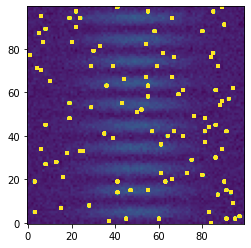

In [5]:
xs = np.linspace(0,1,100)
ys = np.linspace(0,2,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
    return np.exp(-(xx-0.5)**2/0.05)*(np.sin(yy*2*np.pi/(2/5)))**2

data_clean = f(ys,xs)
cosmic_rays = 1000*0.5*(1 + np.sign( (1/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim = data_clean + 0.25*np.random.randn(len(data_clean),len(data_clean[0]))/2 + 1*cosmic_rays

plt.imshow(data_sim, origin='lower', vmax=5)

# Modeling data with an outer product function using scipy.optimize.minimize directly (L1 norm, simulated data)

In [6]:
xlen = len(data_sim[0])
ylen = len(data_sim)

def model(x):
    global xlen, ylen
    assert len(x) == xlen + ylen
    func_x = x[:xlen]
    func_y = x[xlen:]
    return np.outer(func_y, func_x)

def loss(parameters,data):
    return np.sum(np.abs(data - model(parameters)))

In [7]:
initial_guess = np.ones(len(data_sim) + len(data_sim[0]))

start_time = time.time()
guess = spop.minimize(loss,initial_guess,data_sim, options={'maxiter' : 500})
print(time.time()-start_time)

7.921725034713745


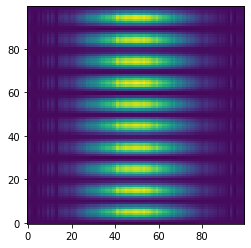

In [8]:
plt.imshow(np.outer(guess.x[xlen:],guess.x[:xlen]), origin='lower', interpolation='none')

# Modelling with reweighted iterative linear regression

## Functions

In [9]:
def remove_zeros(array):
    array = np.array(array).astype(float)
    shape = np.shape(array)
    flattened = array.flatten()
    
    flattened[np.argwhere(flattened == 0)] = np.inf
    flattened[np.argwhere(flattened == np.inf)] = 0.0001
    
    return flattened.reshape(shape)

def minimize(data, init_guess, tol, n_it):
    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    len_y = len(data) 
    
    # Initializing arrays and values
    y = np.empty(len(init_guess[:len_y]))
    x = np.empty(len(init_guess[len_y:]))
    y_prev = np.empty(len(init_guess[:len_y]))
    x_prev = np.empty(len(init_guess[len_y:]))
    y_prev[:] = init_guess[:len_y]
    x_prev[:] = init_guess[len_y:]
    sqerror = np.ones_like(data)
    
    counter = 0
    lsq = 1
    
    while ( lsq > tol and counter < n_it ) or counter == 1:
        counter += 1

        # Updating parameters
        for i in range(len(x)):
            x[i] = np.max([0.0000001,np.matmul(y_prev,data/sqerror)[i]/np.matmul(y_prev**2,1/sqerror)[i]])
        for i in range(len(y)):
            y[i] = np.max([0.0000001,np.matmul(data/sqerror,x_prev)[i]/np.matmul(1/sqerror,x_prev**2)[i]])
        
        # Updating previous guess
        
        y_prev[:] = y[:]
        x_prev[:] = x[:]
        
        # Updating squared error matrix; removing zeroes
        sqerror = np.abs((data - np.outer(y,x)))
        sqerror = remove_zeros(sqerror)

        lsq = np.sum(sqerror)/N**2
        
#         print(f'{lsq}/{tol}, {counter}')

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    return y,x  

## Simulated data

In [13]:
initial_guess = np.concatenate([data_sim[:,50], data_sim[65]])

y_try, x_try = minimize(data_sim, initial_guess, 0.00000001, 500)

Time elapsed is 4.211674928665161. Iterations: 500.


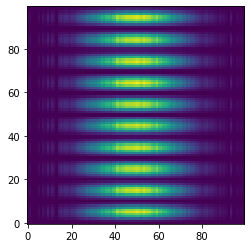

In [15]:
# plt.figure(figsize=(10,10))
plt.imshow(np.outer(y_try,x_try), origin='lower', interpolation='none')
plt.show()

## APOGEE data

In [20]:
initial_guess = np.ones(len(data_actual) + len(data_actual[0]))

y_model, x_model = minimize(data_actual, initial_guess, 0.0000000001, 10)

Time elapsed is 12.111104965209961. Iterations: 10.


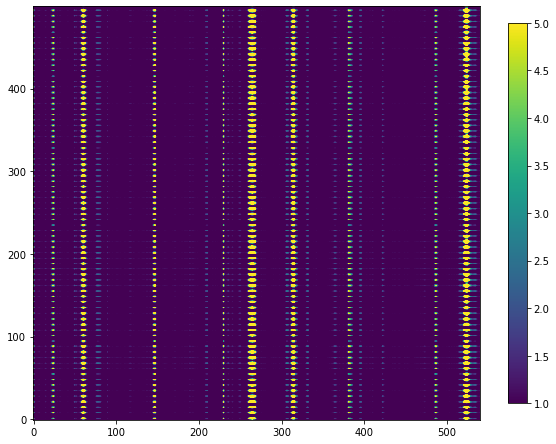

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(np.outer(y_model,x_model), origin='lower', interpolation='none', vmax=5, vmin=1)
plt.colorbar(shrink=0.7)

# for x in np.array(xpix_chipnum1) - 1500:
#     plt.axvline(x,color='white',alpha=0.9, lw=0.5)
# plt.xlim(0,500)

plt.savefig('trial.png')
plt.show()

### Actual APOGEE data

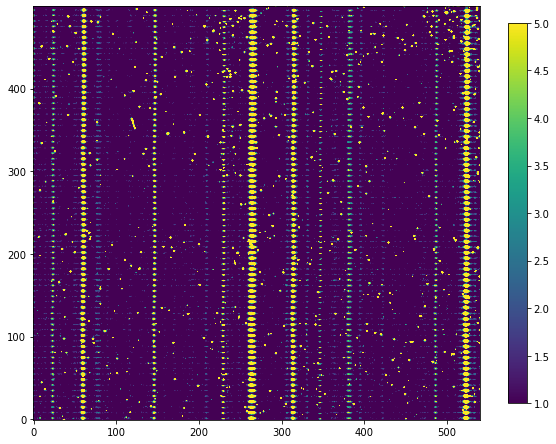

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(data_actual, vmax=5, vmin=1, origin='lower')
plt.colorbar(shrink=0.7)

# for x in np.array(xpix_chipnum1) - 1000:
#     plt.axvline(x,color='red',alpha=0.9, lw=0.5)   
# plt.xlim(0,500)

plt.savefig('actual.png')

(0.0, 500.0)

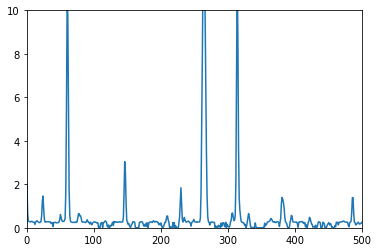

In [196]:
plt.plot(x_try)
plt.ylim(0,10)

# for x in np.array(xpix_chipnum1) - 1500:
#     plt.axvline(x,color='red',alpha=0.9, lw=0.5)
    
plt.xlim(0,500)
# plt.ylim(0,0.5)

### Residue

In [23]:
model = np.outer(y_model,x_model)

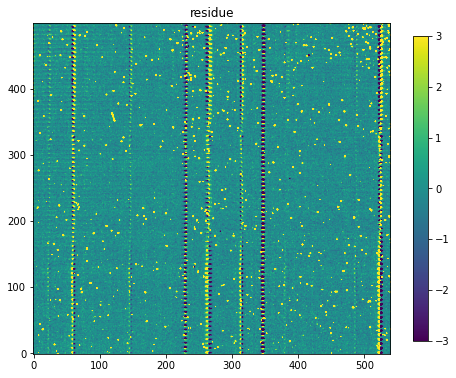

In [83]:
plt.figure(figsize=(8,8))
plt.imshow(data_actual - model, origin='lower', vmax=3, vmin=-3)
plt.colorbar(shrink=0.7)
plt.title('residue')
plt.savefig('residue.png')

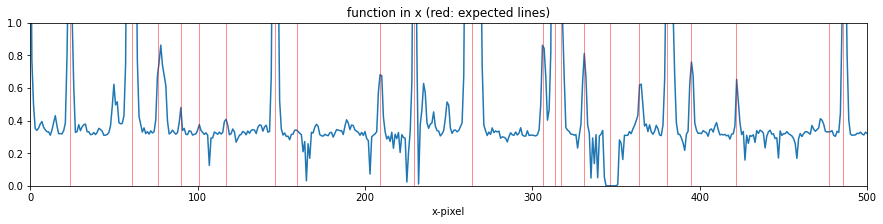

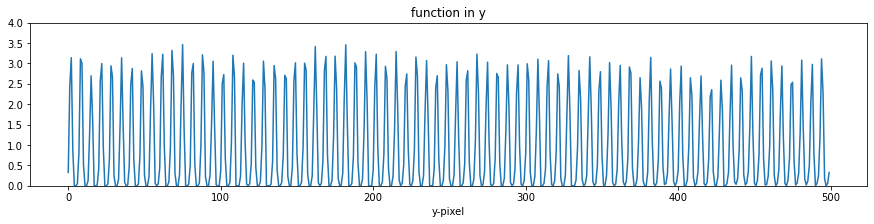

In [85]:
plt.figure(figsize=(15,3))
plt.plot(x_model)
plt.ylim(0,1)
plt.title('function in x (red: expected lines)')
plt.xlabel('x-pixel')


for x in np.array(xpix_chipnum1) - 1500:
    plt.axvline(x,color='red',alpha=0.9, lw=0.5)   
plt.xlim(0,500)

plt.savefig('x_func.png')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(y_model)
plt.ylim(0,4)
plt.title('function in y')
plt.xlabel('y-pixel')
plt.savefig('y_func.png')
plt.show()